# SVM for COVID X-Ray Detection


#### Prepare the data, preprocess it, scale features, reduce dimensions and train using 5-fold Grid Search CV with SVM algorithm

- Trained on 2121 unique Xray images (memory limits, Grid Search training time on local machine - 15hrs)

- All relevant directories at the same level 

- CT Scans discarded

- Only frontal views trained on (no lateral views)

- NULL Labels removed 

- One of 3 target values: COVID, NORMAL, ABNORMAL BUT NON COVID

In [1]:
# Import necessary modules
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
import cv2

## Read in label file 

In [2]:
label_df = pd.read_table('labels_covid19_posi.tsv')
label_df = label_df.replace({'\t': ','}, regex=True)

In [61]:
#label_df

### Create directory to store images

In [3]:
# import os 
# os.mkdir('data')

### Generate labels for ALL studies and drop NULL 

In [5]:
test_sample = []
V1_dirs = os.listdir('V1')
studies = [study for study in V1_dirs if "subjects" in study]
for study in studies:
    subs = os.listdir('V1/'+study)  
    test_sample = test_sample + subs

In [6]:
label_test = label_df[label_df['PatientID'].isin(test_sample)]
label_test.dropna(subset=['Labels'], inplace=True)
# Reset index since nulls removed
label_test.reset_index(inplace=True)
label_test = label_test.drop(['index', 'Unnamed: 0'], axis=1)

<ipython-input-6-84541d6119f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_test.dropna(subset=['Labels'], inplace=True)


In [7]:
#Check shape 

label_test.shape

(1673, 8)

### Create main dataset that maps image ID to appropriate label

#### Label Creation
- If Labels contains COVID 19, assign COVID
- If labels contains normal, assign normal 
- Otherwise, abnormal but non-COVID

In [65]:
#label_df

In [8]:
# Initialize label as empty string
label_test['Label'] = ''

In [9]:
# Iterate over dataset to populate label column
# Manipulate string entry as list to find whether a required label exists 
for i in range(len(label_test)):
    conditions_spaced = label_test['Labels'][i].replace("'", "").strip('][').split(', ')
    conditions = [x.strip(' ') for x in conditions_spaced]
    if 'COVID 19' in conditions:
        label_test['Label'][i] = "COVID"
    elif 'normal' in conditions:
        label_test['Label'][i] = "NORMAL"
    else:
        label_test['Label'][i] = "ABNORMALNONCOVID"

### Go to Directory and find image file name
- Use 'os' to navigate to directory from patient ID and report ID columns 

In [10]:
# Create Image ID column
label_test['ImageID'] = ''

In [11]:
# Here's how a single image ID is located and extracted

# Define main directory where image sub-folders can be found
main_dir = "V1"
img_sub = "mod-rx"

### Populate label column

- Explore the directory corresponding to patient ID and report ID, discard CT scans (no png files will be found) and replicate details if multiple acquisitions are found 

In [12]:
%%time
# Iterate over dataset to populate label column 
new_rows = []

# Make subset of data for each study, then use the index of this subset dataframe to populate larger one
for study in studies:
    subs = os.listdir(main_dir + "/" + study)
    subset_data = label_test[label_test['PatientID'].isin(subs)]

    for i in subset_data.index:
        files = os.listdir(main_dir + "/" + study + "/" + label_test['PatientID'][i] + "/" + label_test['ReportID'][i] + "/" + img_sub)
        # Make sure to remove lateral images
        li = [x for x in files if ".png" in x and "lateral" not in x]

        if len(li) >= 1:
            label_test['ImageID'][i] = li[0]
            # Case for multiple acquisitions, just replicate the row values and change image ID
            if len(li) > 1: 
                for j in range(1, len(li)):
                    row_list = [x for x in label_test.loc[i, :].values.tolist()[:-1]] + [li[j]]
                    new_rows.append(row_list)
        elif len(li) == 0:
            label_test['ImageID'][i] = ""

CPU times: user 734 ms, sys: 283 ms, total: 1.02 s
Wall time: 1.54 s


In [13]:
# Make df with additional rows
df_new_rows = pd.DataFrame(new_rows, columns = label_test.columns)

In [14]:
# Make final df
final_df = pd.concat([label_test, df_new_rows])
final_df = final_df.reset_index()

In [15]:
# Image IDs as empty string are CT scan patients - discard these
final_df = final_df[final_df['ImageID'] != ""]

In [16]:
# Check unique values for ImageID
print("Unique Image IDs: ", len(final_df['ImageID'].unique()))

Unique Image IDs:  2121


In [17]:
# Check for and drop duplicates
ids = final_df["ImageID"]
final_df[ids.isin(ids[ids.duplicated()])]
# Now drop duplicates
final_df = final_df.drop_duplicates(subset=['ImageID'])
final_df = final_df.reset_index()

In [18]:
print("Unique Image IDs: ", len(final_df['ImageID'].unique()))

Unique Image IDs:  2121


### Port images to main data directory

In [35]:
import shutil

# Iterate over dataset to port images into data directory
new_rows = []

for study in studies:
    subs = os.listdir(main_dir + "/" + study)
    subset_data = label_test[label_test['PatientID'].isin(subs)]


    for i in subset_data.index:
        base = main_dir + "/" + study + "/" + subset_data['PatientID'][i] + "/" + subset_data['ReportID'][i] + "/" + img_sub
        files = os.listdir(base)
        li = [x for x in files if ".png" in x]

        for image in li:
            shutil.copy(base + "/" + image, "data")

In [19]:
# Check number of images copied 
len(os.listdir("data"))

2321

In [20]:
# Prepare dataset to be used for the experiment 
experiment_data = final_df[["PatientID", "ReportID", "ImageID", "Label"]]

In [22]:
# Inspect dataset to be used for the experiment
experiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  2121 non-null   object
 1   ReportID   2121 non-null   object
 2   ImageID    2121 non-null   object
 3   Label      2121 non-null   object
dtypes: object(4)
memory usage: 66.4+ KB


## Image processing

### Image manipulation with rgb2grey
Image data is represented as a matrix, where the depth is the number of channels. An RGB image has three channels (red, green, and blue) whereas the returned greyscale image has only one channel. 

In [29]:
# View sample image and manipulate to grayscale
file_path = 'bimcv_covid19_posi_subjects_2/sub-S03086/ses-E06421/mod-rx/sub-S03086_ses-E06421_run-1_bp-chest_vp-ap_dx.png'

In [30]:
image = Image.open(file_path)

img = image.resize((3000, 3000))

xray_test = np.array(img)

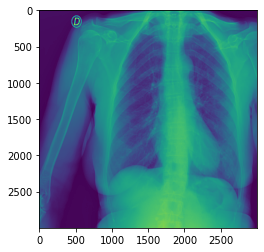

In [31]:
plt.imshow(xray_test)
plt.show()

#### Test OpenCV Equalize Histogram Method for Preprocessing

- Histogram Equalization is a computer image processing technique used to improve contrast in images. 
- It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. 
- This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.

[211 211 184 ...  37  37   0]


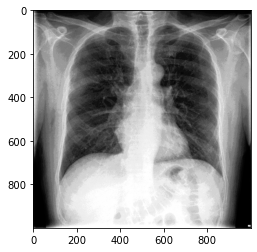

In [95]:
for file in os.listdir('data'):
    img_array = cv2.imread("data/"+file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (1000, 1000))
    equ = cv2.equalizeHist(new_array)
    print(equ.flatten())
    plt.imshow(equ, cmap="gray")
    plt.show()
    break

### Histogram of oriented gradients

HOG, or Histogram of Oriented Gradients, is a feature descriptor that is often used to extract features from image data. 

Crucial Aspects of HOG: 

- The HOG descriptor focuses on the structure or the shape of an object. In the case of edge features, we only identify if the pixel is an edge or not. HOG is able to provide the edge direction as well. This is done by extracting the magnitude and direction of the edges. 

- Additionally, these orientations are calculated in ‘localized’ portions. This means that the complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated. 

- Finally the HOG would generate a Histogram for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’

Source: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

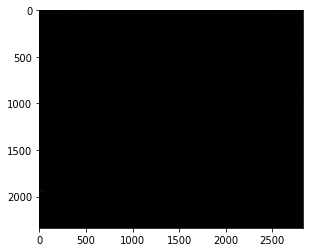

In [114]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_xray,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

### Generate Image Features
- Create image features and flatten into 1D array 
- Test with sample image above

In [41]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [61]:
# def create_features(img):
#     # flatten three channel color image
#     color_features = img.flatten()
#     # convert to greyscale
#     grey_image = rgb2grey(img)
#     # get HOG features from greyscale image
#     #hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
#     # combine color and hog features into a single array
#     #flat_features = np.hstack(grey_image)
#     flat_features = np.hstack(grey_image)
#     return flat_features

# sample_features = create_features(xray_test)

# print(sample_features)

[188 186 185 ...  86  86  86]


In [23]:
def create_features(img):
    flat_features = img.flatten()
    return flat_features

#sample_features = create_features(xray_test)

#print(sample_features)

### Process all images

In [96]:
# Check distribution of value counts
experiment_data.Label.value_counts()

ABNORMALNONCOVID    1138
COVID                721
NORMAL               262
Name: Label, dtype: int64

In [97]:
#Function to get image and return image as an array 

def get_image(row_id, root="data/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = row_id
    file_path = os.path.join(root, filename)
    img_array = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (500, 500))
    equ = cv2.equalizeHist(new_array)
    return equ

In [50]:
%%time
#Function to create feature matrix 

def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.ImageID:
        # load image
        img = get_image(img_id, root="data/")
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(experiment_data)

CPU times: user 4min 51s, sys: 22.7 s, total: 5min 14s
Wall time: 6min 27s


In [98]:
feature_matrix

array([[  0,   0,   0, ...,  37,  25,  15],
       [  0,   0,   0, ..., 153, 153, 153],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 88,  88,  88, ...,   0,   0,   0],
       [245, 246, 245, ..., 152, 158, 171],
       [ 14,  14,  14, ...,   3,   3,   7]], dtype=uint8)

### Feature scaling and Dimensionality Reduction 
- Must reduce the number of features
- Transform the data using PCA: A linear transformation such that most of the information in the data is contained within a smaller number of features called components.

In [53]:
%%time
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# Standard scaler - Need to figure out how best to make feature vector lengths uniform 
ss = StandardScaler()
# run this on our feature matrix
data_scaled = ss.fit_transform(feature_matrix)

# use fit_transform to run PCA on our standardized matrix
pca = PCA(n_components=1000)
data_pca = ss.fit_transform(data_scaled)

# look at new shape
print('PCA matrix shape is: ', data_pca.shape)

Feature matrix shape is:  (2121, 250000)
PCA matrix shape is:  (2121, 250000)
CPU times: user 43.4 s, sys: 1min 47s, total: 2min 31s
Wall time: 5min 19s


### Split the data into training and testing components

In [55]:
# Split into training and test 
X = pd.DataFrame(data_pca)
y = pd.Series(experiment_data.Label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)
 
# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

ABNORMALNONCOVID    810
COVID               493
NORMAL              181
dtype: int64

### Train the model with grid search 

In [56]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.datasets import load_breast_cancer 
from sklearn.svm import SVC 

In [57]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.545, total=13.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.5min remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.545, total=15.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 28.9min remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.545, total=15.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.545, total=14.5min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.547, total=10.7min
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.569, total=14.0min
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.569, total=16.1min
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.535, total=11.1min
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.559, total=13.2min
[CV] C

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 940.8min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [58]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


### Score Model

In [59]:
grid_predictions = grid.predict(X_test) 
  
# calculate accuracy
accuracy = accuracy_score(y_test, grid_predictions)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.5353218210361067
